## Zillow 2017 predictions report:

Got an email from the Zillow DS Team:

<i>"We want to be able to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017.

We have a model already, but we are hoping your insights can help us improve it. I need recommendations on a way to make a better model. <b>Maybe you will create a new feature out of existing ones</b> that works better, try a non-linear regression algorithm, or <b>try to create a different model for each county</b>. Whatever you find that works (or doesn't work) will be useful. Given you have just joined our team, we are excited to see your outside perspective.

One last thing, Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in."</i>

-- The Zillow Data Science Team

___________________________________________________________________________________________________________________

## My Goal: to predict the values of single unit properties using the zillow database obervations from 2017.




### My Deliverables:

- Constructed ML Regression model that predicts propery tax assessed values (and can be used for our marketing and tech departments).

- Finding the key drivers of property value for single family properties. 


### My Questions: 
 

- Do count of bath/bedrooms drive the property value? And if so, is there one more weighted against the other?

- Is there a difference of the average of property values by county? And if so, what is the difference?


### Follow up Questions:

- Can we get data on the population income average per county?

- Can we get the data on school ratings (greatschools.com) and see if this might be a main driver as well?

- Can we gather predictions and data based on other location factors (ie parks, hiking, waterfronts, nearby churches, grocery stores, malls, etc)





In [1]:
#will insert and collect needed imports to repo along the workflow, down below:

In [2]:
import warnings
warnings.filterwarnings("ignore")

#imports for calling in data, cleaning
import pandas as pd
import os
from env import get_db_url
import acquire
import prepare
import evaluate

#imports for exploration phase
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

#imports for stats, modeling and evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from acquire import wrangle_zillow

import datetime
from math import sqrt
plt.rc("axes.spines", top=False, right=False)
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import explained_variance_score
import statsmodels.api as sm

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE

### Acquistion: 
INITIAL ACQUISITION:
We will be calling in the zillow dataset from the MySQL database.
This dataset will only with include taxvaluedollarcnt, bathroom count, bedroom count, calculatedfinishedsquarefeet, transactiondate and fips.

This dataset will also only take in transaction accounts from year 2017. 

In [3]:
# Using MySQL, we will Find all of the "Single Family Residential" properties and transactions from 2017:
df = pd.read_sql("SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, transactiondate, fips FROM properties_2017 JOIN predictions_2017 AS pe USING (parcelid) JOIN propertylandusetype USING (propertylandusetypeid) WHERE propertylandusetype.propertylandusedesc = 'Single Family Residential' AND pe.transactiondate LIKE '2017%%';", get_db_url("zillow"))
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips
0,4.0,2.0,1242.0,590000.0,2017-01-13,6037.0
1,2.0,1.0,864.0,355000.0,2017-01-13,6037.0
2,3.0,2.0,1550.0,2200000.0,2017-01-13,6037.0
3,3.0,2.0,1149.0,185716.0,2017-01-13,6037.0
4,3.0,2.0,1508.0,419389.0,2017-01-13,6037.0


### Acquistion Summary: 
Getting to know the data in dtypes, and any missed nulls from prep


In [4]:
#noting that transactiondate is the only non-numeric column. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   calculatedfinishedsquarefeet  52359 non-null  float64
 3   taxvaluedollarcnt             52440 non-null  float64
 4   transactiondate               52441 non-null  object 
 5   fips                          52441 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.4+ MB


In [5]:
#looking at the counts for each column
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-------------------------------")

bedroomcnt
3.0     23359
4.0     15240
2.0      8340
5.0      3973
6.0       635
1.0       612
0.0       137
7.0       106
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: bedroomcnt, dtype: int64
-------------------------------
bathroomcnt
2.0     21893
3.0     10673
1.0      9568
2.5      3934
4.0      2227
3.5       918
1.5       841
5.0       803
4.5       687
6.0       322
5.5       224
0.0       121
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
11.0        3
8.5         3
18.0        1
13.0        1
Name: bathroomcnt, dtype: int64
-------------------------------
calculatedfinishedsquarefeet
1120.0    128
1200.0    119
1080.0    102
936.0      86
1040.0     86
         ... 
6405.0      1
8531.0      1
4533.0      1
5139.0      1
5124.0      1
Name: calculatedfinishedsquarefeet, Length: 4723, dtype: int64
-------------------------------
taxvaluedollarcnt
455000.0    34
600000.0    30
550000.0    24
50000

In [6]:
#Let's check for any nulls
df.isnull().sum()

bedroomcnt                       0
bathroomcnt                      0
calculatedfinishedsquarefeet    82
taxvaluedollarcnt                1
transactiondate                  0
fips                             0
dtype: int64

In [7]:
#If these nulls are dropped, will it effect the dataset?
round(df.dropna().shape[0] / df.shape[0], 4)

0.9984

### Prep-Clean:

In [8]:
#99% of our data still left? Great! Let's drop them!
df = df.dropna()
df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
transactiondate                 0
fips                            0
dtype: int64

#### Convert Datatyes

- I'll be changing bedroomcnt, finishedsquareft, taxvaluedollar, and fips into integers so as to utilize in continuous testing. 

- I will not change bathroomcnt due to some objects showing 1/2 baths.

- I will not change transaction date as it already is in the format I want. 

In [9]:
##Changing dtype of Fips code so only 4 digits (no decimals)
df['fips'] = df['fips'].astype('int')

In [10]:
#Changing dtype of squarefeet so no decimals
df['calculatedfinishedsquarefeet'] = df['calculatedfinishedsquarefeet'].astype('int')

In [11]:
#Changing dtype of taxvaluedollarcnt as integer
df['taxvaluedollarcnt'] = df['taxvaluedollarcnt'].astype('int')

In [12]:
#changing bedroom count to int
df['bedroomcnt']= df['bedroomcnt'].astype('int')

In [13]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips
0,4,2.0,1242,590000,2017-01-13,6037
1,2,1.0,864,355000,2017-01-13,6037
2,3,2.0,1550,2200000,2017-01-13,6037
3,3,2.0,1149,185716,2017-01-13,6037
4,3,2.0,1508,419389,2017-01-13,6037


### Exploration and Visualization (looking at the data):

In [14]:
#taking a look at the mean and other data stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,52358.0,3.305531,0.941429,0.0,3.00,3.0,4.00,14.0
bathroomcnt,52358.0,2.302781,1.019773,0.0,2.00,2.0,3.00,18.0
calculatedfinishedsquarefeet,52358.0,1922.904618,1004.370420,128.0,1268.00,1659.0,2306.00,21929.0
taxvaluedollarcnt,52358.0,528025.819569,748329.465813,1000.0,193644.25,373376.5,618533.25,49061236.0
fips,52358.0,6049.111158,21.019623,6037.0,6037.00,6037.0,6059.00,6111.0


<AxesSubplot:>

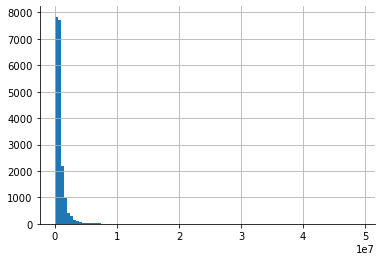

In [15]:
#looking at 100 properties where bathroom count is higher than average
df[df.bathroomcnt > 2.3].taxvaluedollarcnt.hist(bins=100)

<AxesSubplot:>

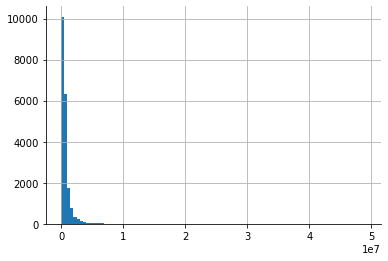

In [16]:
#looking at 100 properties where bedroom count is higher than average

df[df.bedroomcnt > 3.3 ].taxvaluedollarcnt.hist(bins=100)

#### More Visualizations

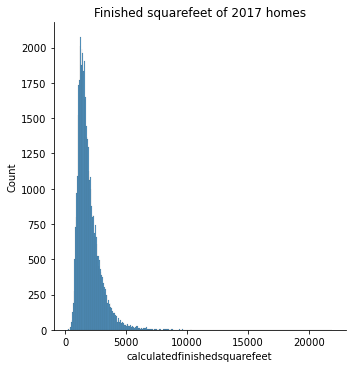

In [17]:
#using sns displot to see values of homes and the years built 
sns.displot(x='calculatedfinishedsquarefeet', data=df)

plt.title('Finished squarefeet of 2017 homes')
plt.show()

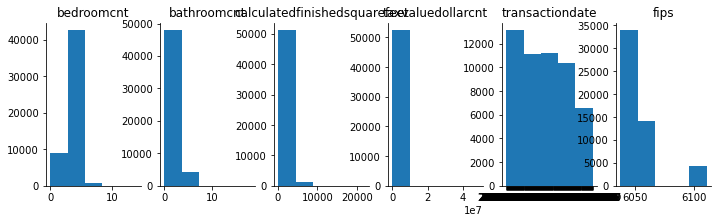

In [18]:
#creating histograms for all the variables

plt.figure(figsize=(16, 3))

# Creates a List of columns:
for i, col in enumerate(df.columns):

    # i starts at 0, but plot numbers should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,8, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

#### Takeaways:
Just these few visuals show me there are some outliers that need to be dropped

### Handling Outliers:
Seeing the size and count of the variables to locate any outliers

#### Squarefootage:

In [19]:
df.calculatedfinishedsquarefeet.sort_values(ascending=False).head(15)

2172     21929
14537    20612
7314     18654
48811    17245
27075    15450
41546    14829
28163    13598
16550    12616
48261    12056
4247     12039
5645     11880
46704    11722
22188    11704
3752     11703
11639    11649
Name: calculatedfinishedsquarefeet, dtype: int64

I'm thinking of narrowing down to only a range of below 9,000sqft homes

In [20]:
#let's see the percentage if we narrowed it down from there
df[df.calculatedfinishedsquarefeet <= 9_000].shape[0] / df.shape[0]


0.9989304404293518

I still would have 99.8% of my data. I feel comfortable narrowing things down to this.


In [21]:
 df = df[df.calculatedfinishedsquarefeet <= 9_000]

Let's look at the lower sqft end:

In [22]:
df[df.calculatedfinishedsquarefeet >= 200].shape[0] / df.shape[0]

0.9999617605445299

Again, I feel comfortable narrowing from this end too:

In [23]:
df = df[df.calculatedfinishedsquarefeet >= 200]

#### Bedroom Count:

In [24]:
df.bedroomcnt.sort_values(ascending=False).head(15)

31641    12
31640    12
31639    12
21163    11
33905    10
49353     9
44250     9
6423      9
11414     9
5289      9
28207     9
36664     8
47879     8
49950     8
47434     8
Name: bedroomcnt, dtype: int64

Hmm...what if I get rid of homes with more than 6 bedrooms?

In [25]:
df[df.bedroomcnt <= 6].shape[0] / df.shape[0]

0.9976099426386233

In [26]:
#that looks good:
df = df[df.bedroomcnt <= 6]

I also will get rid of zero bedrooms as my industry source says these are similar to nulls:

In [27]:
df[df.bedroomcnt != 0].shape[0] / df.shape[0]

0.9988116914230953

In [28]:
#yep, still leaves us with 99.8%
df=df[df.bedroomcnt != 0]

#### Bathroom Count

In [29]:
df.bathroomcnt.sort_values(ascending=False).head(15)

17244    9.0
12617    9.0
38174    9.0
19959    8.5
12546    8.0
27206    8.0
44032    8.0
11187    8.0
15660    8.0
29196    8.0
34867    8.0
36578    8.0
24293    8.0
35553    8.0
7732     8.0
Name: bathroomcnt, dtype: float64

ok. Maybe let's see how much data is left with 6 or less baths?

In [30]:
df[df.bathroomcnt <= 6].shape[0] / df.shape[0]

0.9970256941646038

In [31]:
#cool, let's narrow it here too:
df = df[df.bathroomcnt <= 6]

In [32]:
#also getting rid of properties with no baths
df=df[df.bathroomcnt != 0]

In [33]:
#Let's see how much data we have still....
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51942 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51942 non-null  int64  
 1   bathroomcnt                   51942 non-null  float64
 2   calculatedfinishedsquarefeet  51942 non-null  int64  
 3   taxvaluedollarcnt             51942 non-null  int64  
 4   transactiondate               51942 non-null  object 
 5   fips                          51942 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.8+ MB


In [34]:
#looking at the counts for each column
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-------------------------------")

bedroomcnt
3    23351
4    15218
2     8334
5     3891
1      605
6      543
Name: bedroomcnt, dtype: int64
-------------------------------
bathroomcnt
2.0    21879
3.0    10644
1.0     9544
2.5     3932
4.0     2203
3.5      915
1.5      840
5.0      786
4.5      679
6.0      297
5.5      223
Name: bathroomcnt, dtype: int64
-------------------------------
calculatedfinishedsquarefeet
1120    127
1200    118
1080    102
936      86
1040     86
       ... 
4377      1
5092      1
519       1
4861      1
5124      1
Name: calculatedfinishedsquarefeet, Length: 4489, dtype: int64
-------------------------------
taxvaluedollarcnt
455000    34
600000    30
450000    24
500000    24
550000    24
          ..
159489     1
161962     1
317075     1
635345     1
33325      1
Name: taxvaluedollarcnt, Length: 38507, dtype: int64
-------------------------------
transactiondate
2017-06-30    802
2017-04-28    610
2017-05-31    559
2017-07-28    540
2017-08-31    522
             ... 
2017-08-13     

#### Assessed Value of Home:
Let's see what outliers are here...

In [35]:
df.taxvaluedollarcnt.sort_values(ascending=False).head(15)

50748    20203475
39013    15618488
48381    13600098
8193     13198250
31890    13128583
34897    11317682
36237    11020600
43576    11000000
38702    10873908
3769     10610405
50761    10355345
24257    10130485
50474    10050974
41560     9935000
37551     9870514
Name: taxvaluedollarcnt, dtype: int64

Wow. Maybe I'll see what it looks like for 2M homes or less...

In [36]:
df[df.taxvaluedollarcnt <= 2_000_000].shape[0] / df.shape[0]

0.9771475876939664

In [37]:
#I'll try a little bit more, to get to 98 or 99% still left
df[df.taxvaluedollarcnt <= 2_500_000].shape[0] / df.shape[0]

0.9861961418505256

Yep. Let's take these outliers out too

In [38]:
df = df[df.taxvaluedollarcnt <= 2_500_000]

In [39]:
#other end:
df[df.taxvaluedollarcnt >= 45_000].shape[0] / df.shape[0]

0.9808882381649585

I don't know who is buying these homes at 45,000, but good for them...and I'm taking out the lower end ones

In [40]:
df = df[df.taxvaluedollarcnt >= 45_000]

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50246 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    50246 non-null  int64  
 1   bathroomcnt                   50246 non-null  float64
 2   calculatedfinishedsquarefeet  50246 non-null  int64  
 3   taxvaluedollarcnt             50246 non-null  int64  
 4   transactiondate               50246 non-null  object 
 5   fips                          50246 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.7+ MB


____________________________________________________________________________________________________________

### Missing county/fips codes in:
Thanks Zach for losing those fip codes! ;) 
Here is a function to add those back in.

In [42]:
def clearing_fips(df):
    '''This function takes in a DataFrame of unprepared Zillow information and generates a new
    'county' column, with the county name based on the FIPS code. 
    '''
    # create a list of our conditions
    fips = [
        (df['fips'] == 6037),
        (df['fips'] == 6059),
        (df['fips'] == 6111)
        ]
    # create a list of the values we want to assign for each condition
    counties = ['Los Angeles County', 'Orange County', 'Ventura County']
    # create a new column and use np.select to assign values to it using our lists as arguments
    df['county'] = np.select(fips, counties)
    return df

In [43]:
clearing_fips(df)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county
0,4,2.0,1242,590000,2017-01-13,6037,Los Angeles County
1,2,1.0,864,355000,2017-01-13,6037,Los Angeles County
2,3,2.0,1550,2200000,2017-01-13,6037,Los Angeles County
3,3,2.0,1149,185716,2017-01-13,6037,Los Angeles County
4,3,2.0,1508,419389,2017-01-13,6037,Los Angeles County
...,...,...,...,...,...,...,...
52435,4,2.0,1669,569544,2017-09-06,6059,Orange County
52436,3,2.0,1821,402132,2017-09-06,6037,Los Angeles County
52437,2,1.0,1246,468691,2017-09-06,6037,Los Angeles County
52439,3,2.0,1180,71426,2017-09-06,6037,Los Angeles County


___________________________________________________________________________________________________________

### Creating a new feature to compare value weight to property value:
Time of year for Transactions

I added this as I know (from buying my own homes) that there are high buying and high selling seasons in real estate.

In [44]:
#creating a function to added a column that holds the month number for later testing
def month_sales(df):
    df['month'] = pd.DatetimeIndex(df['transactiondate']).month
    return df

In [45]:
month_sales(df)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county,month
0,4,2.0,1242,590000,2017-01-13,6037,Los Angeles County,1
1,2,1.0,864,355000,2017-01-13,6037,Los Angeles County,1
2,3,2.0,1550,2200000,2017-01-13,6037,Los Angeles County,1
3,3,2.0,1149,185716,2017-01-13,6037,Los Angeles County,1
4,3,2.0,1508,419389,2017-01-13,6037,Los Angeles County,1
...,...,...,...,...,...,...,...,...
52435,4,2.0,1669,569544,2017-09-06,6059,Orange County,9
52436,3,2.0,1821,402132,2017-09-06,6037,Los Angeles County,9
52437,2,1.0,1246,468691,2017-09-06,6037,Los Angeles County,9
52439,3,2.0,1180,71426,2017-09-06,6037,Los Angeles County,9


### >>ALL THE ABOVE IS NOW ADDED INTO THE ACQUIRE .py file<<

_____________________________________________________________________________________________________________________

## Splitting the Data:

- Let's split the data to begin the train, validate, and test process and do some Hypothesis testing:
**<b>Note: this function will be added to the prepare.py file

In [46]:
#Splitting the data into a train/test split of 80/20
#Further splits for train/validate of 70/30
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
print(train.shape, validate.shape, test.shape)

(28137, 8) (12059, 8) (10050, 8)


### Questions 1: Does Bathroom and Bedroom count determine a property's value?

a = 0.05

- H0: Bathroom count does not correlate to property value.
- Ha: Bathroom count does correlate to property value.

In [47]:
#We will try a correlation hypothesis test for bathroom count and taxvaluedollarcnt (property value)
from math import sqrt
from scipy import stats

n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval

x = train.bathroomcnt
y = train.taxvaluedollarcnt

def stdev(x):
    variance = ((x - x.mean()) ** 2).sum() / n
    return sqrt(variance)

r_xy = (((x - x.mean()) * (y - y.mean())).sum() / n) / (stdev(x) * stdev(y))
print('The correlation coefficient is:', r_xy)


The correlation coefficient is: 0.5044283300693065


In [48]:
#calculating corresponding p-value:
# 1 step: t-statistic
t = (r_xy * sqrt(n - 2)) / sqrt(1 - r_xy**2)
t

97.99049291629026

In [49]:
# 2 step: find p value:
p = stats.t.sf(t, df=degf) * 2 # *2 for a two-tailed test
p

0.0

In [50]:
# 3 step: compare p value to our alpha: if our p value is less, then we reject Null Hypothesis

p < α


True

#### We reject the null hypothesis that bathroom count does not correlate to a property's value. 

In [51]:
# Let's visualize these coefficient correlations with a heatmap!
#Creating the correlation matrix for bathroom counts.

bathroom_corr = train.drop(columns=['bathroomcnt']).corr()
bathroom_corr


,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips,month
bedroomcnt,1.000000,0.629158,0.265650,0.145237,0.017503
calculatedfinishedsquarefeet,0.629158,1.000000,0.579966,0.139080,0.018962
taxvaluedollarcnt,0.265650,0.579966,1.000000,0.079339,0.020980
fips,0.145237,0.139080,0.079339,1.000000,0.001091
month,0.017503,0.018962,0.020980,0.001091,1.000000


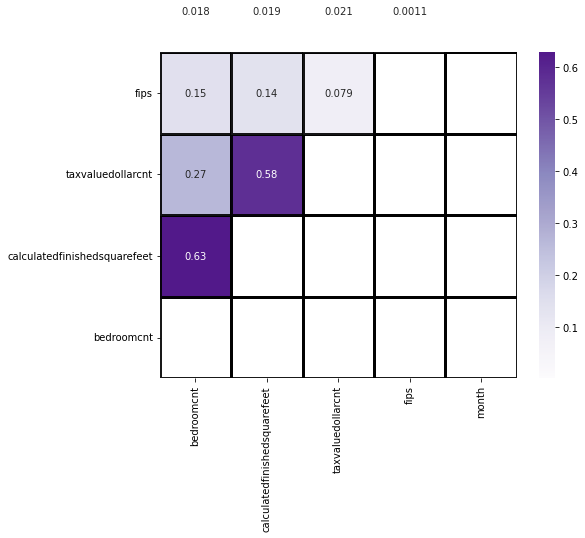

In [52]:
# Pass my correlation matrix to Seaborn's heatmap.

kwargs = {'alpha':.9,'linewidth':3, 'linestyle':'-', 
          'linecolor':'k','rasterized':False, 'edgecolor':'w', 
          'capstyle':'projecting',}

plt.figure(figsize=(8,6))
sns.heatmap(bathroom_corr, cmap='Purples', annot=True, mask= np.triu(bathroom_corr), **kwargs)
plt.ylim(0, 4)

plt.show()


#### TAKEAWAY: Bathroom count looks to definitely correlate with property's value, and it looks like the finished squarefeet may relate to bathroom count too

___________________________________________________________________________________________________________________

Part two of the first question::
a = 0.05

- H0: Bedroom count does not correlate to property value.
- Ha: Bedroom count does correlate to property value.

In [53]:
#We will try a correlation hypothesis test for bathroom count and taxvaluedollarcnt (property value)
from math import sqrt
from scipy import stats

n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval

x = train.bedroomcnt
y = train.taxvaluedollarcnt

def stdev(x):
    variance = ((x - x.mean()) ** 2).sum() / n
    return sqrt(variance)

r_xy = (((x - x.mean()) * (y - y.mean())).sum() / n) / (stdev(x) * stdev(y))
print('The correlation coefficient is:', r_xy)

The correlation coefficient is: 0.2656498353705466


In [54]:
#calculating corresponding p-value:
# 1 step: t-statistic
t = (r_xy * sqrt(n - 2)) / sqrt(1 - r_xy**2)
t

46.21943466415567

In [55]:
# 2 step: find p value:
p = stats.t.sf(t, df=degf) * 2 # *2 for a two-tailed test
p

0.0

In [56]:
# 3 step: compare p value to our alpha: if our p value is less, then we reject Null Hypothesis

p < α


True

#### We reject the null hypothesis that bedroom count does not correlate to a property's value. 


In [57]:
# Let's visualize these coefficient correlations with a heatmap!
#Creating the correlation matrix for bedroom counts.

bedroom_corr = train.drop(columns=['bedroomcnt']).corr()
bedroom_corr


,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips,month
bathroomcnt,1.000000,0.833644,0.504428,0.127767,0.023038
calculatedfinishedsquarefeet,0.833644,1.000000,0.579966,0.139080,0.018962
taxvaluedollarcnt,0.504428,0.579966,1.000000,0.079339,0.020980
fips,0.127767,0.139080,0.079339,1.000000,0.001091
month,0.023038,0.018962,0.020980,0.001091,1.000000


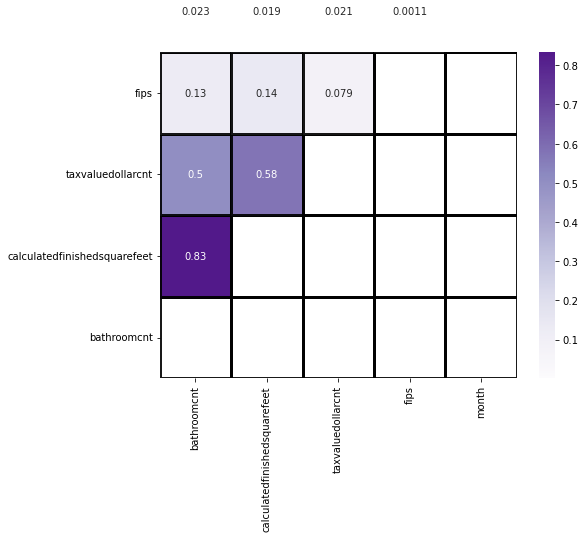

In [58]:
# Pass my correlation matrix to Seaborn's heatmap.

kwargs = {'alpha':.9,'linewidth':3, 'linestyle':'-', 
          'linecolor':'k','rasterized':False, 'edgecolor':'w', 
          'capstyle':'projecting',}

plt.figure(figsize=(8,6))
sns.heatmap(bedroom_corr, cmap='Purples', annot=True, mask= np.triu(bedroom_corr), **kwargs)
plt.ylim(0, 4)

plt.show()

#### TAKEAWAY: Bedroom count looks to definitely correlate with property's value, and it looks like the finished squarefeet With correlation to bathroom count....makes sense though. The more rooms the more bathrooms may be needed!

___________________________________________________________________________________________________________________

### Questions 2: - Is there a difference of the average of property values by county? And if so, what is the difference?

a = 0.05

- H0: County does not correlate to property value.
- Ha: County does correlate to property value.

In [59]:
#We will try a correlation hypothesis test for county (fips as it needs to be numeric)
from math import sqrt
from scipy import stats

n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval

x = train.fips
y = train.taxvaluedollarcnt

def stdev(x):
    variance = ((x - x.mean()) ** 2).sum() / n
    return sqrt(variance)

r_xy = (((x - x.mean()) * (y - y.mean())).sum() / n) / (stdev(x) * stdev(y))
print('The correlation coefficient is:', r_xy)

The correlation coefficient is: 0.07933891055268384


In [60]:
#calculating corresponding p-value:
# 1 step: t-statistic
t = (r_xy * sqrt(n - 2)) / sqrt(1 - r_xy**2)
t

13.349988179199293

In [61]:
# 2 step: find p value:
p = stats.t.sf(t, df=degf) * 2 # *2 for a two-tailed test
p

1.5740809129248938e-40

In [62]:
# 3 step: compare p value to our alpha: if our p value is less, then we reject Null Hypothesis

p < α


True

#### We reject the null hypothesis that county does not correlate to a property's value. 


__________________________________________________________________________________________________________________

### Let's begin looking at our data a bit more by county:

In [63]:
#getting a value_count() by each county
train.county.value_counts()

Los Angeles County    18046
Orange County          7712
Ventura County         2379
Name: county, dtype: int64

Now, Let's create some visuals to see the correlation/relationship 
between county and property value AND we can also add in the bathroom/bedroom counts too here per county

**<b>Note: this function has been added to the viz.py file

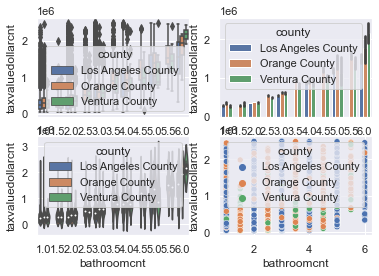

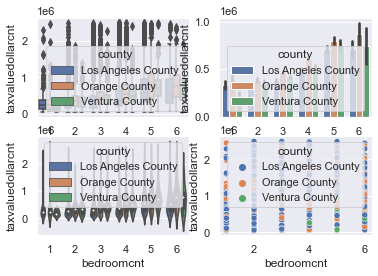

In [64]:
#creating a function that will show 3 different types of plots of the relation between property value/county/features
#all divided into county 
def plot_categorical_and_continuous_vars():
    columns = ['bathroomcnt','bedroomcnt']
    for x in columns:
        sns.set()
        fig, axes = plt.subplots(2,2)
        sns.boxplot(x= x, y="taxvaluedollarcnt", data=train, hue = 'county', ax = axes[0,0])
        sns.barplot(x= x, y="taxvaluedollarcnt", data=train, hue = 'county', ax = axes[0,1])
        sns.violinplot(x= x, y="taxvaluedollarcnt", data=train, hue = 'county', ax = axes[1,0])
        sns.scatterplot(x= x, y="taxvaluedollarcnt", data=train, hue = 'county', ax = axes[1,1])
plot_categorical_and_continuous_vars()
    

#### TAKEAWAY: The charts definitely highlight the rise of property value based on bathroom count, bedroom count and county.

___________________________________________________________________________________________________________________

Last chart per county.
- I found this one to be interesting in adding the regression line within the correlation between county and finished squarefeet
- I used 1/4 of the training data here so that a closer view of what the data errors look like, and also the confidence intervals

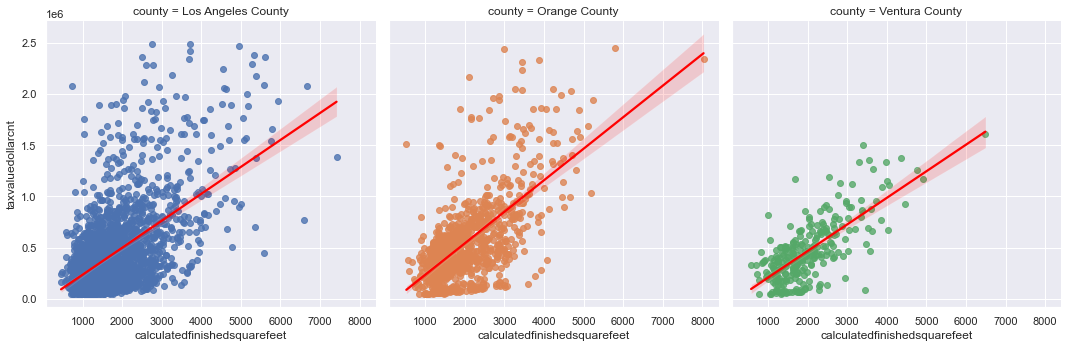

In [65]:
#looking at calculated finished squarefeet and if we can visually gauge any relation here
def plot_variable_pairs():
    columns = ['calculatedfinishedsquarefeet']
    for col in columns:
        sns.lmplot(x= col, y="taxvaluedollarcnt", data=train.sample(3500), col = 'county', hue = 'county', line_kws={'color': 'red'})
        
plot_variable_pairs()

In [66]:
#TODO: 
#add prepare functions/test and split to prepare.py
#add chart functions to viz.py


### Scale the Data:
I want to look at the distribution of my data one more time so I can decide if I want to use a linear or non-linear scale.

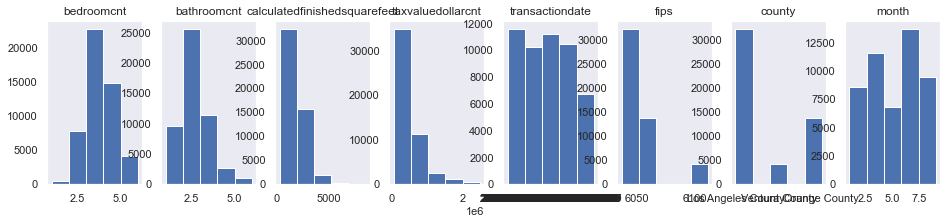

In [67]:
#creating histograms for all the variables

plt.figure(figsize=(16, 3))

# Creates a List of columns:
for i, col in enumerate(train.columns):

    # i starts at 0, but plot numbers should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,8, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

#### For the main features: Bedroom count, Bathroom count and finished squarefeet of properities, we already have a normal distribution, so I will use a Linear Scaler. (but later, I may try again a nonlinear scaler to look at the transaction date and months)

- I will create another split (to keep the unscaled data for possible futher exploring later):

In [68]:
#using a modified copy of the list, I will use Min-Max scaling
#MUST fit scaling to the train columns I am wanting to scale (ie columns_to_scale)
train_scaled = train.copy()
scaler = MinMaxScaler()
columns_to_scale = ['calculatedfinishedsquarefeet']

#A copy of train.                 #adding sklearn scaler.fit_transform to scale wanted columns
train_scaled[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])

In [69]:
#Let's look at the data now scaled
train_scaled

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county,month
49714,2,1.0,0.076543,200164,2017-08-25,6037,Los Angeles County,8
48758,2,1.0,0.047142,241199,2017-08-30,6037,Los Angeles County,8
20886,3,2.0,0.185274,53596,2017-05-04,6037,Los Angeles County,5
42450,3,2.0,0.303130,818939,2017-08-02,6037,Los Angeles County,8
19447,2,3.0,0.166646,134320,2017-04-14,6037,Los Angeles County,4
...,...,...,...,...,...,...,...,...
7754,3,3.0,0.250919,404651,2017-02-03,6059,Orange County,2
47482,6,4.0,0.367634,1043534,2017-09-05,6059,Orange County,9
4334,4,2.0,0.277531,477004,2017-01-19,6037,Los Angeles County,1
14980,4,2.0,0.104930,270562,2017-04-06,6037,Los Angeles County,4


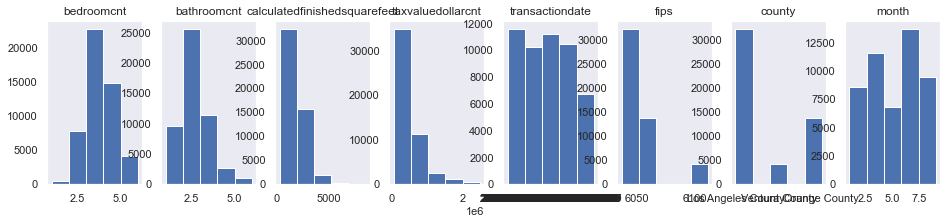

In [70]:
#creating histograms for all the train_scaled variables
columns = ['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt']
plt.figure(figsize=(16, 3))

# Creates a List of columns:
for i, col in enumerate(train_scaled.columns):

    # i starts at 0, but plot numbers should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,8, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)


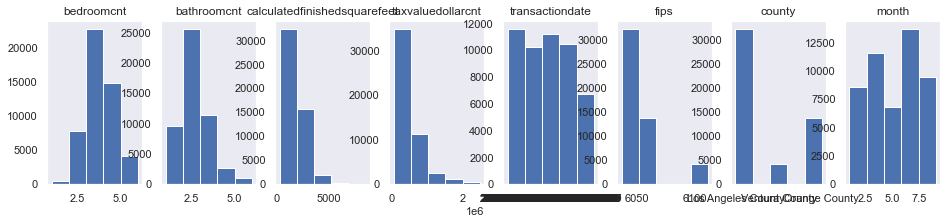

In [71]:
#compared to unscaled data
columns = ['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt']
plt.figure(figsize=(16, 3))

# Creates a List of columns:
for i, col in enumerate(train.columns):

    # i starts at 0, but plot numbers should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,8, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)


In [72]:
#here is my data pipeline function for scaling:
def scale_data(train,
              validate,
              test,
              columns_to_scale=['calculatedfinishedsquarefeet'],
              return_scaler=False):
    """
    Scales the 3 data splits.
    Takes in train, validate and test data splits and then returns their scaled counterparts.
    If return_scaler is True, the scaler object will be returned as well
    """
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    #using MinMaxScaler (best showing distribution once scaled)
    scaler = MinMaxScaler()
    scaler.fit(train[columns_to_scale])
    
    #creating a df that puts MinMaxScaler to work on the wanted columns and returns the split datasets and counterparts
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                 columns=train[columns_to_scale].columns.values).set_index([train.index.values])
    
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                 columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [73]:
scaler, train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, return_scaler=True)

In [74]:
train_scaled

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county,month
49714,2,1.0,0.076543,200164,2017-08-25,6037,Los Angeles County,8
48758,2,1.0,0.047142,241199,2017-08-30,6037,Los Angeles County,8
20886,3,2.0,0.185274,53596,2017-05-04,6037,Los Angeles County,5
42450,3,2.0,0.303130,818939,2017-08-02,6037,Los Angeles County,8
19447,2,3.0,0.166646,134320,2017-04-14,6037,Los Angeles County,4
...,...,...,...,...,...,...,...,...
7754,3,3.0,0.250919,404651,2017-02-03,6059,Orange County,2
47482,6,4.0,0.367634,1043534,2017-09-05,6059,Orange County,9
4334,4,2.0,0.277531,477004,2017-01-19,6037,Los Angeles County,1
14980,4,2.0,0.104930,270562,2017-04-06,6037,Los Angeles County,4


### >>Above has been added to prepare.py file! <<

___________________________________________________________________________________________________________________

### Evaluating Models:
*note: will be moving this section to the bottom on Final Report. Had here as I was following the curriculum workflow suggestions, but it is not hepful here.

In [75]:
#first I will drop the columns not needed (or scaled) to fit the calculatedfinishedsquarefeet onto a Linear regression model
train_scaled.drop(columns = ['bedroomcnt', 'bathroomcnt', 'fips','month'], inplace=True)

In [76]:
#creating a new df for evaluating models specifically:
X_train = train_scaled[['calculatedfinishedsquarefeet']]
y_train = train_scaled['taxvaluedollarcnt']

X_validate = validate_scaled[['calculatedfinishedsquarefeet']]
y_validate = validate_scaled['taxvaluedollarcnt']

X_test = test_scaled[['calculatedfinishedsquarefeet']]
y_test = test_scaled['taxvaluedollarcnt']

In [77]:
#taking a look at what we have here...
X_train

,calculatedfinishedsquarefeet
49714,0.076543
48758,0.047142
20886,0.185274
42450,0.303130
19447,0.166646
...,...
7754,0.250919
47482,0.367634
4334,0.277531
14980,0.104930


#### First model evaluation: Ordinary Least Squares:

In [78]:
# create the model object and fit the model to train_scaled data
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_train)

In [79]:
#creating the zillow predictor baseline aka mean, of taxvaluedollarcnt(y)
baseline = train_scaled.taxvaluedollarcnt.mean()
baseline

466402.11003305257

In [80]:
train_scaled['yhat'] = predictions

In [81]:
#let's add the baseline to the the dataframe
train_scaled['baseline'] = train_scaled.taxvaluedollarcnt.mean()
train_scaled.head()

,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,county,yhat,baseline
49714,0.076543,200164,2017-08-25,Los Angeles County,225035.527768,466402.110033
48758,0.047142,241199,2017-08-30,Los Angeles County,163381.304123,466402.110033
20886,0.185274,53596,2017-05-04,Los Angeles County,453049.854869,466402.110033
42450,0.303130,818939,2017-08-02,Los Angeles County,700198.251378,466402.110033
19447,0.166646,134320,2017-04-14,Los Angeles County,413984.463163,466402.110033


- Now, I want to plot the residuals for the OLS model I made:

In [82]:
# first I need to create residuals (ie residuals = actual - predicted)
train_scaled['residual'] = train_scaled.taxvaluedollarcnt - train_scaled.yhat
train_scaled['baseline_residual'] = train_scaled.taxvaluedollarcnt - train_scaled.baseline
train_scaled.head()

,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,county,yhat,baseline,residual,baseline_residual
49714,0.076543,200164,2017-08-25,Los Angeles County,225035.527768,466402.110033,-24871.527768,-266238.110033
48758,0.047142,241199,2017-08-30,Los Angeles County,163381.304123,466402.110033,77817.695877,-225203.110033
20886,0.185274,53596,2017-05-04,Los Angeles County,453049.854869,466402.110033,-399453.854869,-412806.110033
42450,0.303130,818939,2017-08-02,Los Angeles County,700198.251378,466402.110033,118740.748622,352536.889967
19447,0.166646,134320,2017-04-14,Los Angeles County,413984.463163,466402.110033,-279664.463163,-332082.110033


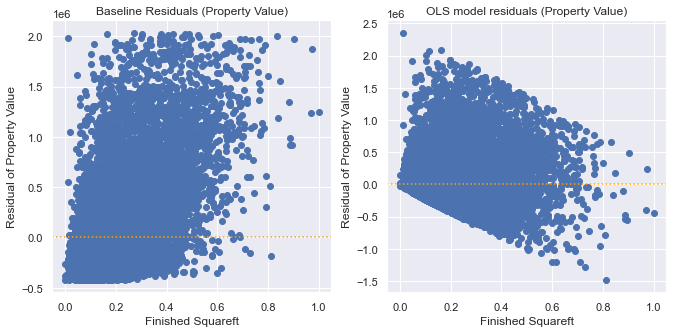

In [83]:
#Let's plot!
#Here are the residual plots (calculated finished square feet vs residual)

###METHODS USED:

plt.figure(figsize = (11,5))

plt.subplot(121)
plt.scatter(train_scaled.calculatedfinishedsquarefeet, train_scaled.baseline_residual)
plt.axhline(y = 0, ls = ':', color ='orange')
plt.xlabel('Finished Squareft')
plt.ylabel('Residual of Property Value')
plt.title('Baseline Residuals (Property Value)')

plt.subplot(122)
plt.scatter(train_scaled.calculatedfinishedsquarefeet, train_scaled.residual)
plt.axhline(y = 0, ls = ':', color ='orange')
plt.xlabel('Finished Squareft')
plt.ylabel('Residual of Property Value')
plt.title('OLS model residuals (Property Value)');

#### Evaluate Statistically:
Next, let's look at the stats side of this model. I can evaluate statistically with:
- Calculating the sum of squared errors, 
- explained sum of squares, 
- total sum of squares, 
- mean squared error, 
- and root mean squared error for your model.

Then, I will calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model for comparison sake (i.e. a model that always predicts the average taxvaluedollarcnt amount).



In [84]:
# I first will calculate the square of residuals (makes all the residuals positive)

train_scaled['residual^2'] = train_scaled.residual**2
train_scaled['baseline_residual^2'] = train_scaled.baseline_residual**2

train_scaled.head()

,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,county,yhat,baseline,residual,baseline_residual,residual^2,baseline_residual^2
49714,0.076543,200164,2017-08-25,Los Angeles County,225035.527768,466402.110033,-24871.527768,-266238.110033,6.185929e+08,7.088273e+10
48758,0.047142,241199,2017-08-30,Los Angeles County,163381.304123,466402.110033,77817.695877,-225203.110033,6.055594e+09,5.071644e+10
20886,0.185274,53596,2017-05-04,Los Angeles County,453049.854869,466402.110033,-399453.854869,-412806.110033,1.595634e+11,1.704089e+11
42450,0.303130,818939,2017-08-02,Los Angeles County,700198.251378,466402.110033,118740.748622,352536.889967,1.409937e+10,1.242823e+11
19447,0.166646,134320,2017-04-14,Los Angeles County,413984.463163,466402.110033,-279664.463163,-332082.110033,7.821221e+10,1.102785e+11


In [85]:
#SUM OF SQUARED ERRORS:
SSE = train_scaled['residual^2'].sum()
SSE_baseline = train_scaled['baseline_residual^2'].sum()

print('SSE =', "{:.1f}".format(SSE))
print("SSE Baseline =", "{:.1f}".format(SSE_baseline))
if SSE < SSE_baseline:
    print ('Model beats baseline')
else:
    print ('Baseline beats model')

SSE = 2802991495147791.0
SSE Baseline = 4223668589927059.0
Model beats baseline


In [86]:
#MEAN OF SQUARED ERROR: (error at each observation level)
MSE = SSE/len(train_scaled)
MSE_baseline = SSE_baseline/len(train_scaled)

print("MSE = ", "{:.1f}".format(MSE))
print("MSE baseline = ", "{:.1f}".format(MSE_baseline))
if MSE < MSE_baseline:
    print ('Model beats baseline')
else:
    print ('Baseline beats model')

MSE =  99619415543.5
MSE baseline =  150110835907.4
Model beats baseline


In [87]:
#TOTAL SUM OF SQUARES
TSS = SSE = train_scaled['residual^2'].sum()
TSS_baseline = SSE_baseline = train_scaled['baseline_residual^2'].sum()
print("TSS = ","{:.1f}".format(TSS)) 
print("TSS_baseline = ","{:.1f}".format(TSS_baseline))
if TSS < TSS_baseline:
    print ('Model beats baseline')
else:
    print ('Baseline beats model')

TSS =  2802991495147791.0
TSS_baseline =  4223668589927059.0
Model beats baseline


In [88]:
#EXPLAINED SUM of SQUARES
ESS = TSS - SSE
ESS_baseline = TSS_baseline - SSE-baseline
print("ESS = ","{:.1f}".format(ESS))
print("ESS_baseline = ","{:.1f}".format(ESS_baseline))

ESS =  0.0
ESS_baseline =  1420677094312866.0


In [89]:
#ROOT MEAN SQUARED ERROR
RMSE = sqrt(MSE)
RMSE_baseline =  sqrt(MSE_baseline)


print("RMSE = ", "{:.1f}".format(RMSE))
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))


RMSE =  315625.4
RMSE baseline =  387441.4


In [90]:
ols_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
ols_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])

ols_eval['model_error'] = np.array([SSE, MSE, RMSE])
ols_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])

print(ols_eval)
print(ols_baseline_eval)


  metric   model_error
0    SSE  2.802991e+15
1    MSE  9.961942e+10
2   RMSE  3.156254e+05
          metric   model_error
0   SSE_baseline  4.223669e+15
1   MSE_baseline  1.501108e+11
2  RMSE_baseline  3.874414e+05


In [91]:
ols_eval['error_delta'] = ols_eval.model_error - ols_baseline_eval.model_error
ols_eval


,metric,model_error,error_delta
0,SSE,2.802991e+15,-1.420677e+15
1,MSE,9.961942e+10,-5.049142e+10
2,RMSE,3.156254e+05,-7.181596e+04


Text(103, 90, '')

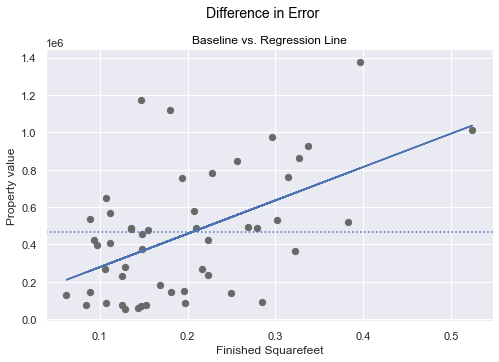

In [92]:
sample = train_scaled.sample(50)
baseline = sample.baseline
yhat = sample.yhat
x = sample.calculatedfinishedsquarefeet
y = sample.taxvaluedollarcnt


plt.figure(figsize=(8, 5))
## plot data points, regression line and baseline
    # plot the data points 
plt.scatter(x, y, color='dimgray', s=40)

#### plot the regression line
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
#add linear regression line to scatterplot 
plt.plot(x, m*x+b)

# add baseline through annotation
# for each x apply y to make line across chart
plt.axhline(train.taxvaluedollarcnt.mean(), ls = ':')
#### set and plot title, subtitle, and axis labels
# set titles
title_string = r'Difference in Error'
subtitle_string = "Baseline vs. Regression Line"

    # add titles
plt.title(subtitle_string, fontsize=12, color='black')
plt.suptitle(title_string, y=1, fontsize=14, color='black')
    
    # add axes labels
plt.ylabel('Property value')
plt.xlabel('Finished Squarefeet')

# annotate some of the error lines with pointers
    # add pointer: the first data point to the regression line
plt.annotate('.', xy=(70.25, 70), xytext=(73, 70), xycoords='data', textcoords='data', arrowprops={'arrowstyle': 'fancy', 'color':'darkseagreen', 'linewidth': 1})

    # add pointer: the last data point to the regression line
plt.annotate('', xy=(100.25, 97), xytext=(103, 97), xycoords='data', textcoords='data', arrowprops={'arrowstyle': 'fancy', 'color':'darkseagreen', 'linewidth': 1})

    # add pointer: the last data point to the baseline 
plt.annotate('', xy=(100.25, 90), xytext=(103, 90), xycoords='data', textcoords='data', arrowprops={'arrowstyle': 'fancy', 'color':'goldenrod', 'linewidth': 1})

    ## ----------------------------------------
    ## add text to the annotatations
    # the error of the first data point to the regression line
#plt.text(73, 70, 4.1, ha='left', va='center', color='black')

    # the error of the last data point to the regression line
#plt.text(103, 96, 1.6, ha='left', va='center', color='black')

    # the error of the last data point to the baseline
#plt.text(103, 90, -12.7, ha='left', va='center', color='black')


Last, I want to look at the dispersion of errors by creating an Explained Variance Score:

In [93]:
#creating an explained variance score to determine the dipersion of errors in the data set
## (aka, how much of the data the model can accurately predict...)
evs = explained_variance_score(train_scaled.taxvaluedollarcnt, train_scaled.yhat)
print('Explained Variance = ', round(evs,3))


Explained Variance =  0.336


In [94]:
### Is this model better than the baseline model?
X2 = sm.add_constant(train.calculatedfinishedsquarefeet)
est = sm.OLS(train.taxvaluedollarcnt, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      taxvaluedollarcnt   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                 1.426e+04
Date:                Thu, 09 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:15:01   Log-Likelihood:            -3.9620e+05
No. Observations:               28137   AIC:                         7.924e+05
Df Residuals:                   28135   BIC:                         7.924e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

##### Takeaway here:

- OLS Regression Model outperformed baseline model on test using RMSE as evaluation metric
    - OLS Regression Model RMSE: 315625.4
    - Baseline Regression Model: 387441.4

- 34% of variance predictions is not great. Hoping to find something better.

- <b>My assessment: 
    - The stats tests are showing that the OLS model is still doing better than baseline...even with too high/low predictors.
    - More features predictors for this test would probably make the model even better.

### >> ABOVE FUNCTIONS AND LINEAR REG. FUNCTIONS IN EVALUATE.py FILE <<

### Feature Engineering:
I'll be using SelectK Best feature engineering to find the best features that have the strongest relationship with the target variable (taxvaluedollarcnt) and also creating a Recursive Feature Elimination to get the ranking of all variables (finding top feature drivers).

In [95]:
#first, I need to make a new X_train, y_train copy to bring in more features
#looking back at train...
train
#making the new X_train, & y_train with scaled data

scaler, train_scaled2, validate_scaled2, test_scaled2 = scale_data(train, validate, test, return_scaler=True)

train_scaled2

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county,month
49714,2,1.0,0.076543,200164,2017-08-25,6037,Los Angeles County,8
48758,2,1.0,0.047142,241199,2017-08-30,6037,Los Angeles County,8
20886,3,2.0,0.185274,53596,2017-05-04,6037,Los Angeles County,5
42450,3,2.0,0.303130,818939,2017-08-02,6037,Los Angeles County,8
19447,2,3.0,0.166646,134320,2017-04-14,6037,Los Angeles County,4
...,...,...,...,...,...,...,...,...
7754,3,3.0,0.250919,404651,2017-02-03,6059,Orange County,2
47482,6,4.0,0.367634,1043534,2017-09-05,6059,Orange County,9
4334,4,2.0,0.277531,477004,2017-01-19,6037,Los Angeles County,1
14980,4,2.0,0.104930,270562,2017-04-06,6037,Los Angeles County,4


In [96]:
#creating a new df for to feature:
X_train_scaled = train_scaled2[['bedroomcnt','calculatedfinishedsquarefeet','bathroomcnt','fips','month']]
y_train_scaled = train_scaled2['taxvaluedollarcnt']

X_validate_scaled = validate_scaled2[['calculatedfinishedsquarefeet','bedroomcnt','bathroomcnt','fips','month']]
y_validate_scaled = validate_scaled2['taxvaluedollarcnt']

X_test_scaled = test_scaled2[['calculatedfinishedsquarefeet','bedroomcnt','bathroomcnt','fips','month']]
y_test_scaled = test_scaled2['taxvaluedollarcnt']



### TAKEAWAYS: 
- Using Feature Engineering rankings, Bedroom count and Squareft are my prime drivers for property value predictions.

__________________________________________________________________

## Modeling:

>### Developing the baseline:
- I first need to create the baseline model, so that I can later compare how the new models predict the property value vs what is being predicted now. 

#note: these steps will be added to the model.py file to replicate

In [97]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train2 = y_train.copy()
y_validate2 = y_validate.copy()

y_train_baseline = pd.DataFrame(y_train2)
y_validate_baseline = pd.DataFrame(y_validate2)

# 1. Predict Property Value mean
value_pred_mean = y_train_baseline['taxvaluedollarcnt'].mean()
y_train_baseline['value_pred_mean'] = value_pred_mean
y_validate_baseline['value_pred_mean'] = value_pred_mean

# 2. compute Property value mean
value_pred_median = y_train_baseline['taxvaluedollarcnt'].median()
y_train_baseline['value_pred_median'] = value_pred_median
y_validate_baseline['value_pred_median'] = value_pred_median

# 3. RMSE of Property value mean
rmse_train_baseline_mean = mean_squared_error(y_train_baseline.taxvaluedollarcnt, y_train_baseline.value_pred_mean)**(1/2)
rmse_validate_baseline_mean = mean_squared_error(y_validate_baseline.taxvaluedollarcnt, y_validate_baseline.value_pred_mean)**(1/2)

print("RMSE_baseline using Mean\nTrain/In-Sample: ", round(rmse_train_baseline_mean, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_baseline_mean, 2))

# 4. RMSE of Property Value median
rmse_train_baseline_median = mean_squared_error(y_train_baseline.taxvaluedollarcnt, y_train_baseline.value_pred_median)**(1/2)
rmse_validate_baseline_median = mean_squared_error(y_validate_baseline.taxvaluedollarcnt, y_validate_baseline.value_pred_median)**(1/2)

print("RMSE_baseline using Median\nTrain/In-Sample: ", round(rmse_train_baseline_median, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_baseline_median, 2))


RMSE_baseline using Mean
Train/In-Sample:  387441.4 
Validate/Out-of-Sample:  396704.16
RMSE_baseline using Median
Train/In-Sample:  398660.42 
Validate/Out-of-Sample:  409118.72


In [98]:
y_train_baseline.head()

,taxvaluedollarcnt,value_pred_mean,value_pred_median
49714,200164,466402.110033,372491.0
48758,241199,466402.110033,372491.0
20886,53596,466402.110033,372491.0
42450,818939,466402.110033,372491.0
19447,134320,466402.110033,372491.0


In [99]:
#creating the zillow predictor baseline aka mean, of taxvaluedollarcnt(y)
baseline = y_train_baseline.taxvaluedollarcnt.mean()
baseline

466402.11003305257

In [100]:
#let's add yhat columns to hold the baseline predictions
y_train_baseline['yhat'] = predictions

In [101]:
#let's add the baseline to the the dataframe
y_train_baseline['baseline'] = y_train_baseline.taxvaluedollarcnt.mean()
y_train_baseline.head()

,taxvaluedollarcnt,value_pred_mean,value_pred_median,yhat,baseline
49714,200164,466402.110033,372491.0,225035.527768,466402.110033
48758,241199,466402.110033,372491.0,163381.304123,466402.110033
20886,53596,466402.110033,372491.0,453049.854869,466402.110033
42450,818939,466402.110033,372491.0,700198.251378,466402.110033
19447,134320,466402.110033,372491.0,413984.463163,466402.110033


### MODELING TIME!

>## LinearRegression (OLS)
- Fit the model using X_train_scaled and the labels from y_train.

- Predict Property Values in training sample using our model (lm).

- Evaluate using RMSE (as RMSE squares (and makes larger) the errors.

- Repeat predictions and evaluation for validation.

- Compare RMSE train vs. validation. Overfitting?

(ds.codeup.com/regression/model/)

In [102]:
#Bringing in the scaled data
prepare.scale_data(train, validate, test)


#X_train_scaled = train_scaled[['calculatedfinishedsquarefeet','transactiondate','']]

(       bedroomcnt  bathroomcnt  calculatedfinishedsquarefeet  \
 49714         0.2          0.0                      0.076543   
 48758         0.2          0.0                      0.047142   
 20886         0.4          0.2                      0.185274   
 42450         0.4          0.2                      0.303130   
 19447         0.2          0.4                      0.166646   
 ...           ...          ...                           ...   
 7754          0.4          0.4                      0.250919   
 47482         1.0          0.6                      0.367634   
 4334          0.6          0.2                      0.277531   
 14980         0.6          0.2                      0.104930   
 41872         0.6          0.3                      0.196806   
 
        taxvaluedollarcnt transactiondate  fips              county  month  
 49714           0.063169      2017-08-25  6037  Los Angeles County      8  
 48758           0.079884      2017-08-30  6037  Los Angeles Cou

In [103]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train)

# predict train
train_predictions = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train, train_predictions)**(1/2)

# predict validate
validate_predictions = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate, validate_predictions)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
print("-----------------------------------------------------")
print('Baseline:')

print("RMSE_baseline using Mean\nTrain/In-Sample: ", round(rmse_train_baseline_mean, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_baseline_mean, 2))
print("-----------------------------------------------------")
print("RMSE_baseline using Median\nTrain/In-Sample: ", round(rmse_train_baseline_median, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_baseline_median, 2))
print("-----------------------------------------------------")

if rmse_train < rmse_train_baseline_median:
    print('CONCLUSION: OLS BEATS BASELINE MODEL')
else:
    print('Baseline is best choice over OLS')
    
##RMSE IS showing dollar amount (fully linear) and shows how much error by dollar I am, and can compare to difference of baseline.

RMSE for OLS using LinearRegression
Training/In-Sample:  315625.43551417365 
Validation/Out-of-Sample:  323827.3669886513
-----------------------------------------------------
Baseline:
RMSE_baseline using Mean
Train/In-Sample:  387441.4 
Validate/Out-of-Sample:  396704.16
-----------------------------------------------------
RMSE_baseline using Median
Train/In-Sample:  398660.42 
Validate/Out-of-Sample:  409118.72
-----------------------------------------------------
CONCLUSION: OLS BEATS BASELINE MODEL


### Let's evaluate the OLS Model:

I first need to plot the residuals of the OLS Model:

In [104]:
# first I need to create residuals (ie residuals = actual - predicted)
y_train['residual'] = y_train.taxvaluedollarcnt - y_train.yhat
y_train['baseline_residual'] = y_train.taxvaluedollarcnt - y_train.baseline
y_train.head()

AttributeError: 'Series' object has no attribute 'taxvaluedollarcnt'

In [ ]:
from sklearn.metrics import mean_squared_error

SSE2 = mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat)*len(y_train)
SSE2_baseline = mean_squared_error(y_train.taxvaluedollarcnt, y_train.baseline)*len(y_train)

print("SSE manual == SSE sklearn: ", SSE == SSE2) 
print("SSE manual - baseline == SSE sklearn - baseline: ", SSE_baseline == SSE2_baseline) 


In [ ]:
RMSE2 = sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat))
RMSE2_baseline = sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.baseline))

print("RMSE manual == RMSE skearn: ", RMSE == RMSE2) 
print("RMSE manual - baseline == RMSE skearn - baseline: ", RMSE_baseline == RMSE2_baseline) 


> I'll be using both SelectKBest and Recursive Feature Elimination to determine best features for predicting which drivers in the model are best predictors

In [ ]:
##Using SelectKBest to find which features are best a predicting property value:

from sklearn.feature_selection import SelectKBest, f_regression
#this creates, fits, and puts out the shape of the data after using this test


# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=3)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
f_feature

> Creating a Recursive Feature Elimination to rank the key drivers for property value.

In [ ]:
#Using a Recursive Feature Elimination to 
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=2)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
# view list of columns and their ranking in order of most relative to property value, to least relative.

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')


In [ ]:
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
df_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])

df_eval['model_error'] = np.array([SSE, MSE, RMSE])
df_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])

print(df_eval)
print(df_baseline_eval)


### Takeaways:
- The Model <i> DOES </i> beat baseline, there still is a large error.

>## LassoLars with an alpha of 1.0:
- Fit the model using X_train_scaled and the labels from y_train.

- Predict Property Values in training sample using our model (lars).

- Evaluate using RMSE (squares errors to be larger to easily compare)

- Repeat predictions and evaluation for validation.

- Compare RMSE train vs. validation. Overfitting

(ds.codeup.com/regression/model/)

In [ ]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.value_pred_lars)**(1/2)

# predict validate
y_validate['value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
print("-----------------------------------------------------")
print('Baseline:')

print("RMSE_baseline using Mean\nTrain/In-Sample: ", round(rmse_train_baseline_mean, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_baseline_mean, 2))
print("-----------------------------------------------------")
print("RMSE_baseline using Median\nTrain/In-Sample: ", round(rmse_train_baseline_median, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_baseline_median, 2))
print("-----------------------------------------------------")

if rmse_train < rmse_train_baseline_median:
    print('CONCLUSION: LASSOLARS BEATS BASELINE MODEL')
else:
    print('Baseline is best choice over LassoLars')
    

In [ ]:
##insert variance score....

### TAKEAWAY: 


>## TweedieRegressor (GLM) with an alpha of 0 and power 1:
- Fit the model using X_train_scaled and the labels from y_train.

- Predict Property Values in training sample using our model (lars).

- Evaluate using RMSE (squares errors to be larger to easily compare)

- Repeat predictions and evaluation for validation.

- Compare RMSE train vs. validation. Overfitting

(ds.codeup.com/regression/model/)

In [ ]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.value_pred_glm)**(1/2)

# predict validate
y_validate['value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

print("-----------------------------------------------------")
print('Baseline:')

print("RMSE_baseline using Mean\nTrain/In-Sample: ", round(rmse_train_baseline_mean, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_baseline_mean, 2))
print("-----------------------------------------------------")
print("RMSE_baseline using Median\nTrain/In-Sample: ", round(rmse_train_baseline_median, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_baseline_median, 2))
print("-----------------------------------------------------")

if rmse_train < rmse_train_baseline_median:
    print('CONCLUSION: GLM BEATS BASELINE MODEL')
else:
    print('Baseline is best choice over GLM')
    

In [ ]:
### add variance score...

### TAKEAWAY: 

________________________________________________________________

>## Polynomial Regression with an alpha of 0 and power 1:
- Create the new features, based on value indicated for degree for train, validate & test.

-Fit the Linear Regression model

-Predict using the transformed (squared or cubed, e.g.) features

-Evaluate using RMSE

-Repeat predictions and evaluation for validation.

-Compare RMSE train vs. validation. Overfitting?

(ds.codeup.com/regression/model/)

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)


In [ ]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.taxvaluedollarcnt)

# predict train
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.value_pred_lm2)**(1/2)

# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
print("-----------------------------------------------------")
print('Baseline:')

print("RMSE_baseline using Mean\nTrain/In-Sample: ", round(rmse_train_baseline_mean, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_baseline_mean, 2))
print("-----------------------------------------------------")
print("RMSE_baseline using Median\nTrain/In-Sample: ", round(rmse_train_baseline_median, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_baseline_median, 2))
print("-----------------------------------------------------")

if rmse_train < rmse_train_baseline_median:
    print('CONCLUSION: POLYNOMIAL REG of 2 DEGREES BEATS BASELINE MODEL')
else:
    print('Baseline is best choice over Polynomial Regression of 2degrees')


### TAKEAWAY: 

What would this model look like with a degree of 3?

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)


In [107]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train, y_train)

# predict train
train_pred3 = lm3.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, train_pred3)**(1/2)

# predict validate
validate_pred3 = lm3.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, validate_pred3)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

print("-----------------------------------------------------")
print('Baseline:')

print("RMSE_baseline using Mean\nTrain/In-Sample: ", round(rmse_train_baseline_mean, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_baseline_mean, 2))
print("-----------------------------------------------------")
print("RMSE_baseline using Median\nTrain/In-Sample: ", round(rmse_train_baseline_median, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_baseline_median, 2))
print("-----------------------------------------------------")

if rmse_train < rmse_train_baseline_median:
    print('CONCLUSION: POLYNOMIAL OF 3 BEATS BASELINE MODEL')
else:
    print('Baseline is best choice over POLYNOMIAL OF 3')

AttributeError: 'Series' object has no attribute 'taxvaluedollarcnt'

### TAKEAWAY: 

In [ ]:
import matplotlib.pyplot as plt

# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.taxvaluedollarcnt, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(validate_scaled.value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(validate_scaled.value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(validate_scaled.value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Final Grade (G3)")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual Grades to Distributions of Predicted Grades for the Top Models")
plt.legend()
plt.show()



### MODELING EVALUATION TAKEAWAYS:
- Each model did better than the current Zillow baseline model, so any chosen would at least propel the DS team forward in Property Predictions.
- I chose OLS (Linear Regression) model.
    * <b>My model trained at erroring 315,625 (dollars)
    * This beats the error count of baseline: 398,660 (dollars)
    * <b> Meaning: 83,035 (dollars) of accurate prediction happening. 
    * Variance score: 33% 

## TEST THE MODEL!!!

In [105]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['value_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.value_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)


RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  319272.8998425409


## TAKE AWAYS: 
Our model is still holding true and doing better than our baseline!